<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/MonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IMonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordings With Convolutional Neural Networks - Using Spike Rates

## Setup

### Environment Setup
Run the cells in this section to configure the local or Google Colab environments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys

try:
    from google.colab import files
    %tensorflow_version 2.x  # Only on colab
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)

    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    os.chdir('MonkeyPFCSaccadeStudies')
    
    !pip install -q kaggle
    !pip install -U scikit-learn
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from indl.display import turbo_cmap

In [4]:
# Configure plotting defaults.
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

### Download data if necessary

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### Prepare to load data

We will use a custom function load_macaque_pfc to load the data into memory.

There are 4 different strings to be passed to the import x_chunk argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze' - Returns 2-channel gaze data.
* 'spikerates' - Returns smoothed spikerates
* 'spiketrains'

The y_type argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis.

In [6]:
from misc.misc import load_macaque_pfc, sess_infos

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': True,
    'y_type': 'sacClass',  # Integer 0:7 for 8 different targets.
    'samples_last': True  # Our EEGNet blocks expect time-samples in the last dimension.
}

## Decoding trial class (0:7) from spike rates

### Load Data

Load the per-trial spikerates and saccadeClass (0:7)

In [7]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


### Create Model

Our model objective is to transform timeseries segments into probabilities of each class.

Let's start with a function to make the model:

In [8]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer
from tensorflow.keras import layers


@check_inputs
def make_model(
        _input,
        F1=8, kernLength=25, F1_kern_reg=None,
        D=2, D_pooling=4,
        F2=8, F2_kernLength=16,
        F2_pooling=8,
        dropoutRate=0.25,
        activation='elu',
        l1_reg=0.000, l2_reg=0.000,
        norm_rate=0.25,
        latent_dim=16,
        return_model=True
    ):
    
    if F1_kern_reg is None:
        F1_kern_reg = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    elif isinstance(F1_kern_reg, str) and F1_kern_reg == 'kern_length_regu':
        F1_kern_reg = KernelLengthRegularizer((1, kernLength),
                                              window_scale=1e-4,
                                              window_func='poly',
                                              poly_exp=2,
                                              threshold=0.0015)
        
    # EEGNetEnc 
    _y = parts.EEGNetEnc(_input,
                         F1=F1,
                         F1_kernLength=kernLength,
                         F1_kern_reg=F1_kern_reg,
                         D=D,
                         D_pooling=D_pooling,
                         F2=F2,
                         F2_pooling=F2_pooling,
                         F2_kernLength=F2_kernLength,
                         dropoutRate=dropoutRate)
    
    # Restore time-dimension that was stripped out by EEGNetEnc
    _y = layers.Reshape((1, _input.shape.as_list()[2] // D_pooling // F2_pooling, F2))(_y)
    
    # Dense
    _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    _y = parts.Classify(_y, n_classes=8, norm_rate=norm_rate)
    
    if return_model:
        return tf.keras.models.Model(inputs=[_input], outputs=[_y])
    else:
        return _y

Parameterize the model and preview the model.
 

In [44]:
from indl.data.augmentations import random_slice
from functools import partial

MAX_OFFSET = 0

p_random_slice_trn = partial(random_slice, max_offset=MAX_OFFSET)
p_random_slice_vld = partial(random_slice, training=False, max_offset=MAX_OFFSET)

def rates2dataset(X, y, is_train=True, batch_size=16):
    temp_ds = tf.data.Dataset.from_tensor_slices((X, y))
    
    # cast data types to GPU-friendly types.
    temp_ds = temp_ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
    
    # augmentations (random slicing)
    if MAX_OFFSET > 0:
        temp_ds = temp_ds.map(p_random_slice_trn if is_train else p_random_slice_vld)
    
    if is_train:
        temp_ds = temp_ds.shuffle(X.shape[0] + 1)
        
    temp_ds = temp_ds.batch(batch_size, drop_remainder=is_train)
    
    return temp_ds


In [45]:
LABEL_SMOOTHING = 0.2
model_kwargs = dict(
    F1=8, kernLength=25, F1_kern_reg=None,
    D=2, D_pooling=4,
    F2=8, F2_kernLength=16,
    F2_pooling=8,
    dropoutRate=0.30,
    activation='relu',
    l1_reg=0.000, l2_reg=0.003,
    norm_rate=0.25,
    latent_dim=16
)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

temp_ds = rates2dataset(X_rates, Y_class)

model = make_model(
    temp_ds.element_spec[0],
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
model.summary()
if False:
    tf.keras.utils.plot_model(
        model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 171)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 171, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 171, 8)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 171, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 171, 16)        528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 171, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 171, 16)        0     

### Training loop


In [46]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 180


def get_hists_acc(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        
        ds_train = rates2dataset(X_rates[trn], _y[trn], is_train=True, batch_size=BATCH_SIZE)
        ds_valid = rates2dataset(X_rates[vld], _y[vld], is_train=False, batch_size=BATCH_SIZE)
        
        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(
            ds_train.element_spec[0],
            **model_kwargs
        )
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'rates2class_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld, :, MAX_OFFSET:]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Session {sess_id} overall accuracy: {accuracy}%")
    
    return history, accuracy
        

Test training on one session.

Processing session sra3_1_j_050_00+...
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
Train for 15 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to rates2class_sra3_1_j_050_00+_split0.h5
15/15 - 1s - loss: 2.0931 - accuracy: 0.1792 - val_loss: 2.0778 - val_accuracy: 0.2500
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.25000 to 0.28125, saving model to rates2class_sra3_1_j_050_00+_split0.h5
15/15 - 0s - loss: 2.0430 - accuracy: 0.1875 - val_loss: 2.0645 - val_accuracy: 0.2812
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.28125
15/15 - 0s - loss: 1.9858 - accuracy: 0.2833 - val_loss: 2.0355 - val_accuracy: 0.2812
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.28125 to 0.34375, saving model to r

Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.84375
15/15 - 0s - loss: 1.2933 - accuracy: 0.7667 - val_loss: 1.2086 - val_accuracy: 0.8438
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.84375
15/15 - 0s - loss: 1.2797 - accuracy: 0.7208 - val_loss: 1.2004 - val_accuracy: 0.7500
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.84375
15/15 - 0s - loss: 1.2815 - accuracy: 0.7792 - val_loss: 1.1938 - val_accuracy: 0.8125
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.84375
15/15 - 0s - loss: 1.2880 - accuracy: 0.7458 - val_loss: 1.1877 - val_accuracy: 0.8125
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.84375
15/15 - 0s - loss: 1.2664 - accuracy: 0.7583 - val_loss: 1.1950 - val_accuracy: 0.8125
Epoch 51/180

Epoch 00051: val_accuracy improved from 0.84375 to 0.87500, saving model to rates2class_sra3_1_j_050_00+_split0.h5
15/15 - 0s - loss: 1.2929 - accuracy: 0.7417 - val_loss: 1.1810 - val_accuracy: 0.8750
Epoc

Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1654 - accuracy: 0.8500 - val_loss: 1.1346 - val_accuracy: 0.8125
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.2096 - accuracy: 0.7958 - val_loss: 1.1288 - val_accuracy: 0.8125
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1780 - accuracy: 0.8208 - val_loss: 1.1348 - val_accuracy: 0.7500
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1593 - accuracy: 0.8667 - val_loss: 1.1304 - val_accuracy: 0.8125
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.2290 - accuracy: 0.8042 - val_loss: 1.1387 - val_accuracy: 0.8125
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1909 - accuracy: 0.8292 - val_loss: 1.1325 - val_accuracy: 0.7812
Epoch 105/180

Epoch 00105: val_accuracy did not improve fr

Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1282 - accuracy: 0.8917 - val_loss: 1.1335 - val_accuracy: 0.7500
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1193 - accuracy: 0.8500 - val_loss: 1.1528 - val_accuracy: 0.7812
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1533 - accuracy: 0.8375 - val_loss: 1.1445 - val_accuracy: 0.7812
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1387 - accuracy: 0.8708 - val_loss: 1.1386 - val_accuracy: 0.7500
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1710 - accuracy: 0.8333 - val_loss: 1.1256 - val_accuracy: 0.7812
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.87500
15/15 - 0s - loss: 1.1611 - accuracy: 0.8458 - val_loss: 1.1214 - val_accuracy: 0.8125
Epoch 158/180

Epoch 00158: val_accuracy did not improve f

Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.4565 - accuracy: 0.6000 - val_loss: 1.3601 - val_accuracy: 0.5806
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.3871 - accuracy: 0.6542 - val_loss: 1.3572 - val_accuracy: 0.5806
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.4135 - accuracy: 0.5792 - val_loss: 1.3483 - val_accuracy: 0.6129
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.3896 - accuracy: 0.6542 - val_loss: 1.3405 - val_accuracy: 0.6129
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.4006 - accuracy: 0.5708 - val_loss: 1.3354 - val_accuracy: 0.5806
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.64516
15/15 - 0s - loss: 1.3680 - accuracy: 0.6792 - val_loss: 1.3341 - val_accuracy: 0.6129
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.6

Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2531 - accuracy: 0.7583 - val_loss: 1.2744 - val_accuracy: 0.6774
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2210 - accuracy: 0.7833 - val_loss: 1.2892 - val_accuracy: 0.6452
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2229 - accuracy: 0.7958 - val_loss: 1.2891 - val_accuracy: 0.6452
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2232 - accuracy: 0.8000 - val_loss: 1.3084 - val_accuracy: 0.6452
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2453 - accuracy: 0.7667 - val_loss: 1.2659 - val_accuracy: 0.7097
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.70968
15/15 - 0s - loss: 1.2029 - accuracy: 0.8375 - val_loss: 1.2675 - val_accuracy: 0.6452
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.7

Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1689 - accuracy: 0.8625 - val_loss: 1.2322 - val_accuracy: 0.7419
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1661 - accuracy: 0.8250 - val_loss: 1.2284 - val_accuracy: 0.7097
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1839 - accuracy: 0.8375 - val_loss: 1.2365 - val_accuracy: 0.7097
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1743 - accuracy: 0.8458 - val_loss: 1.2493 - val_accuracy: 0.7097
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1581 - accuracy: 0.8583 - val_loss: 1.2656 - val_accuracy: 0.6774
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1883 - accuracy: 0.8417 - val_loss: 1.2861 - val_accuracy: 0.6774
Epoch 132/180

Epoch 00132: val_accuracy did not improve f

Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1397 - accuracy: 0.8792 - val_loss: 1.2501 - val_accuracy: 0.6774
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.74194
15/15 - 0s - loss: 1.1358 - accuracy: 0.8375 - val_loss: 1.2420 - val_accuracy: 0.7097
	Split 3 of 10
Train for 15 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.26667, saving model to rates2class_sra3_1_j_050_00+_split2.h5
15/15 - 1s - loss: 2.0835 - accuracy: 0.1792 - val_loss: 2.0802 - val_accuracy: 0.2667
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.26667 to 0.33333, saving model to rates2class_sra3_1_j_050_00+_split2.h5
15/15 - 0s - loss: 2.0492 - accuracy: 0.2250 - val_loss: 2.0700 - val_accuracy: 0.3333
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.33333 to 0.36667, saving model to rates2class_sra3_1_j_050_00+_split2.h5
15/15 - 0s - loss: 1.9859 - accuracy: 0.2583 - val_loss: 2.0431 - val_accur

Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.3296 - accuracy: 0.6542 - val_loss: 1.1618 - val_accuracy: 0.8667
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.2977 - accuracy: 0.7083 - val_loss: 1.1543 - val_accuracy: 0.8667
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.2741 - accuracy: 0.7583 - val_loss: 1.1493 - val_accuracy: 0.8667
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.3045 - accuracy: 0.7125 - val_loss: 1.1391 - val_accuracy: 0.8667
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.2880 - accuracy: 0.7583 - val_loss: 1.1267 - val_accuracy: 0.8667
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.86667
15/15 - 0s - loss: 1.3058 - accuracy: 0.6917 - val_loss: 1.1209 - val_accuracy: 0.8667
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.8

Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2079 - accuracy: 0.8042 - val_loss: 1.0378 - val_accuracy: 0.9000
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2148 - accuracy: 0.8125 - val_loss: 1.0394 - val_accuracy: 0.9000
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2174 - accuracy: 0.8000 - val_loss: 1.0231 - val_accuracy: 0.9000
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2065 - accuracy: 0.8125 - val_loss: 1.0241 - val_accuracy: 0.9000
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2014 - accuracy: 0.8208 - val_loss: 1.0324 - val_accuracy: 0.8667
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.1957 - accuracy: 0.7917 - val_loss: 1.0285 - val_accuracy: 0.9000
Epoch 105/180

Epoch 00105: val_accuracy did not improve fr

Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1778 - accuracy: 0.8167 - val_loss: 1.0142 - val_accuracy: 0.9000
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1586 - accuracy: 0.8583 - val_loss: 1.0052 - val_accuracy: 0.9333
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1829 - accuracy: 0.8417 - val_loss: 0.9981 - val_accuracy: 0.9333
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1625 - accuracy: 0.8333 - val_loss: 0.9922 - val_accuracy: 0.9667
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1106 - accuracy: 0.8917 - val_loss: 0.9889 - val_accuracy: 0.9667
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1553 - accuracy: 0.8292 - val_loss: 1.0039 - val_accuracy: 0.9000
Epoch 157/180

Epoch 00157: val_accuracy did not improve f

Epoch 21/180

Epoch 00021: val_accuracy did not improve from 0.66667
15/15 - 0s - loss: 1.4390 - accuracy: 0.5583 - val_loss: 1.3803 - val_accuracy: 0.5667
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.66667
15/15 - 0s - loss: 1.4180 - accuracy: 0.5875 - val_loss: 1.3710 - val_accuracy: 0.6000
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.66667
15/15 - 0s - loss: 1.3982 - accuracy: 0.6167 - val_loss: 1.3617 - val_accuracy: 0.6667
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.66667
15/15 - 0s - loss: 1.4147 - accuracy: 0.5750 - val_loss: 1.3504 - val_accuracy: 0.6667
Epoch 25/180

Epoch 00025: val_accuracy improved from 0.66667 to 0.70000, saving model to rates2class_sra3_1_j_050_00+_split3.h5
15/15 - 0s - loss: 1.4118 - accuracy: 0.6125 - val_loss: 1.3438 - val_accuracy: 0.7000
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.70000
15/15 - 0s - loss: 1.3911 - accuracy: 0.6333 - val_loss: 1.3354 - val_accuracy: 0.7000
Epoc

Epoch 72/180

Epoch 00072: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2459 - accuracy: 0.7708 - val_loss: 1.1198 - val_accuracy: 0.9000
Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2539 - accuracy: 0.7375 - val_loss: 1.1245 - val_accuracy: 0.9333
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2525 - accuracy: 0.7875 - val_loss: 1.1297 - val_accuracy: 0.8667
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2324 - accuracy: 0.7792 - val_loss: 1.1131 - val_accuracy: 0.8667
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2619 - accuracy: 0.7750 - val_loss: 1.1065 - val_accuracy: 0.9000
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.93333
15/15 - 0s - loss: 1.2709 - accuracy: 0.7625 - val_loss: 1.1121 - val_accuracy: 0.9000
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.9

Epoch 124/180

Epoch 00124: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1825 - accuracy: 0.8292 - val_loss: 1.0520 - val_accuracy: 0.9000
Epoch 125/180

Epoch 00125: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1755 - accuracy: 0.8417 - val_loss: 1.0519 - val_accuracy: 0.9000
Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1823 - accuracy: 0.8417 - val_loss: 1.0565 - val_accuracy: 0.9000
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1499 - accuracy: 0.8667 - val_loss: 1.0591 - val_accuracy: 0.9000
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1614 - accuracy: 0.8500 - val_loss: 1.0656 - val_accuracy: 0.9000
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1140 - accuracy: 0.8958 - val_loss: 1.0678 - val_accuracy: 0.9000
Epoch 130/180

Epoch 00130: val_accuracy did not improve f

Epoch 177/180

Epoch 00177: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1179 - accuracy: 0.8833 - val_loss: 1.0476 - val_accuracy: 0.9000
Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1503 - accuracy: 0.8625 - val_loss: 1.0542 - val_accuracy: 0.9000
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1582 - accuracy: 0.8292 - val_loss: 1.0573 - val_accuracy: 0.9000
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.96667
15/15 - 0s - loss: 1.1074 - accuracy: 0.8875 - val_loss: 1.0466 - val_accuracy: 0.9000
	Split 5 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.27586, saving model to rates2class_sra3_1_j_050_00+_split4.h5
16/16 - 1s - loss: 2.0869 - accuracy: 0.1445 - val_loss: 2.0768 - val_accuracy: 0.2759
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.27586 to 0.31034, saving model to rates2class_sra

Epoch 45/180

Epoch 00045: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2995 - accuracy: 0.7461 - val_loss: 1.2107 - val_accuracy: 0.7241
Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2939 - accuracy: 0.7422 - val_loss: 1.2115 - val_accuracy: 0.7241
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2989 - accuracy: 0.7422 - val_loss: 1.2170 - val_accuracy: 0.6897
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2988 - accuracy: 0.7070 - val_loss: 1.2130 - val_accuracy: 0.7241
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2752 - accuracy: 0.7422 - val_loss: 1.2093 - val_accuracy: 0.7241
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2807 - accuracy: 0.7578 - val_loss: 1.2051 - val_accuracy: 0.7241
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.7

Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2174 - accuracy: 0.8203 - val_loss: 1.1875 - val_accuracy: 0.7586
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1983 - accuracy: 0.8047 - val_loss: 1.1961 - val_accuracy: 0.7931
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1908 - accuracy: 0.8086 - val_loss: 1.2044 - val_accuracy: 0.7931
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2011 - accuracy: 0.8125 - val_loss: 1.1986 - val_accuracy: 0.7586
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1875 - accuracy: 0.8516 - val_loss: 1.2168 - val_accuracy: 0.7241
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1487 - accuracy: 0.8477 - val_loss: 1.2101 - val_accuracy: 0.7586
Epoch 104/180

Epoch 00104: val_accuracy did not improve fro

Epoch 150/180

Epoch 00150: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1077 - accuracy: 0.9062 - val_loss: 1.1947 - val_accuracy: 0.7931
Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1260 - accuracy: 0.8906 - val_loss: 1.1647 - val_accuracy: 0.8276
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0939 - accuracy: 0.8867 - val_loss: 1.1558 - val_accuracy: 0.8621
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1417 - accuracy: 0.8555 - val_loss: 1.1726 - val_accuracy: 0.8621
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1043 - accuracy: 0.9023 - val_loss: 1.1753 - val_accuracy: 0.8621
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1354 - accuracy: 0.8789 - val_loss: 1.1544 - val_accuracy: 0.8621
Epoch 156/180

Epoch 00156: val_accuracy did not improve f

Epoch 20/180

Epoch 00020: val_accuracy did not improve from 0.60714
16/16 - 0s - loss: 1.4411 - accuracy: 0.5547 - val_loss: 1.3437 - val_accuracy: 0.5714
Epoch 21/180

Epoch 00021: val_accuracy did not improve from 0.60714
16/16 - 0s - loss: 1.4284 - accuracy: 0.6055 - val_loss: 1.3380 - val_accuracy: 0.6071
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.60714
16/16 - 0s - loss: 1.4222 - accuracy: 0.5742 - val_loss: 1.3338 - val_accuracy: 0.6071
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.60714
16/16 - 0s - loss: 1.4237 - accuracy: 0.6172 - val_loss: 1.3317 - val_accuracy: 0.6071
Epoch 24/180

Epoch 00024: val_accuracy improved from 0.60714 to 0.64286, saving model to rates2class_sra3_1_j_050_00+_split5.h5
16/16 - 0s - loss: 1.4009 - accuracy: 0.6289 - val_loss: 1.3282 - val_accuracy: 0.6429
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.64286
16/16 - 0s - loss: 1.3790 - accuracy: 0.6211 - val_loss: 1.3197 - val_accuracy: 0.6429
Epoc

Epoch 71/180

Epoch 00071: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.2262 - accuracy: 0.7773 - val_loss: 1.2963 - val_accuracy: 0.7500
Epoch 72/180

Epoch 00072: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.2577 - accuracy: 0.7539 - val_loss: 1.3081 - val_accuracy: 0.7143
Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1881 - accuracy: 0.8008 - val_loss: 1.3103 - val_accuracy: 0.7143
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1810 - accuracy: 0.8320 - val_loss: 1.2716 - val_accuracy: 0.7500
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.2267 - accuracy: 0.8164 - val_loss: 1.3010 - val_accuracy: 0.7143
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1849 - accuracy: 0.8359 - val_loss: 1.2698 - val_accuracy: 0.7500
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.7

Epoch 124/180

Epoch 00124: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1242 - accuracy: 0.8789 - val_loss: 1.2310 - val_accuracy: 0.7857
Epoch 125/180

Epoch 00125: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1650 - accuracy: 0.8438 - val_loss: 1.2305 - val_accuracy: 0.7857
Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1150 - accuracy: 0.8984 - val_loss: 1.2283 - val_accuracy: 0.7857
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1418 - accuracy: 0.8555 - val_loss: 1.2396 - val_accuracy: 0.7857
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1597 - accuracy: 0.8594 - val_loss: 1.2467 - val_accuracy: 0.7857
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1458 - accuracy: 0.8633 - val_loss: 1.2376 - val_accuracy: 0.7857
Epoch 130/180

Epoch 00130: val_accuracy did not improve f

Epoch 176/180

Epoch 00176: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1305 - accuracy: 0.8828 - val_loss: 1.1987 - val_accuracy: 0.7857
Epoch 177/180

Epoch 00177: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1350 - accuracy: 0.8867 - val_loss: 1.2001 - val_accuracy: 0.7857
Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1005 - accuracy: 0.9219 - val_loss: 1.2304 - val_accuracy: 0.7857
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1144 - accuracy: 0.8867 - val_loss: 1.2158 - val_accuracy: 0.7857
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1271 - accuracy: 0.8711 - val_loss: 1.2029 - val_accuracy: 0.7857
	Split 7 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to rates2class_sra3_1_j_050_00+_split6.h5
16/16 - 1s - loss: 2.1086 - accura

Epoch 44/180

Epoch 00044: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3115 - accuracy: 0.6953 - val_loss: 1.2019 - val_accuracy: 0.8571
Epoch 45/180

Epoch 00045: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.2953 - accuracy: 0.6914 - val_loss: 1.2197 - val_accuracy: 0.8571
Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.2708 - accuracy: 0.7539 - val_loss: 1.2030 - val_accuracy: 0.8571
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.2837 - accuracy: 0.7227 - val_loss: 1.2196 - val_accuracy: 0.8214
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.2760 - accuracy: 0.7617 - val_loss: 1.1927 - val_accuracy: 0.8571
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.2675 - accuracy: 0.7500 - val_loss: 1.2104 - val_accuracy: 0.8214
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.8

Epoch 97/180

Epoch 00097: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1825 - accuracy: 0.8438 - val_loss: 1.1503 - val_accuracy: 0.8571
Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1669 - accuracy: 0.8555 - val_loss: 1.1639 - val_accuracy: 0.8214
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1697 - accuracy: 0.8516 - val_loss: 1.1502 - val_accuracy: 0.8214
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1724 - accuracy: 0.8555 - val_loss: 1.1581 - val_accuracy: 0.8214
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1523 - accuracy: 0.8750 - val_loss: 1.1488 - val_accuracy: 0.8571
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1516 - accuracy: 0.8438 - val_loss: 1.1381 - val_accuracy: 0.8929
Epoch 103/180

Epoch 00103: val_accuracy did not improve from

Epoch 150/180

Epoch 00150: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1453 - accuracy: 0.8672 - val_loss: 1.1602 - val_accuracy: 0.8929
Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1353 - accuracy: 0.8438 - val_loss: 1.1674 - val_accuracy: 0.8571
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1133 - accuracy: 0.9023 - val_loss: 1.1369 - val_accuracy: 0.8214
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1349 - accuracy: 0.8750 - val_loss: 1.1677 - val_accuracy: 0.8571
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1292 - accuracy: 0.8789 - val_loss: 1.1613 - val_accuracy: 0.8571
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1384 - accuracy: 0.8789 - val_loss: 1.1663 - val_accuracy: 0.8214
Epoch 156/180

Epoch 00156: val_accuracy did not improve f

Epoch 20/180

Epoch 00020: val_accuracy did not improve from 0.61538
16/16 - 0s - loss: 1.4404 - accuracy: 0.5820 - val_loss: 1.3208 - val_accuracy: 0.6154
Epoch 21/180

Epoch 00021: val_accuracy improved from 0.61538 to 0.65385, saving model to rates2class_sra3_1_j_050_00+_split7.h5
16/16 - 0s - loss: 1.4183 - accuracy: 0.6133 - val_loss: 1.3139 - val_accuracy: 0.6538
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.65385
16/16 - 0s - loss: 1.4273 - accuracy: 0.5625 - val_loss: 1.3077 - val_accuracy: 0.6154
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.65385
16/16 - 0s - loss: 1.4040 - accuracy: 0.6133 - val_loss: 1.3011 - val_accuracy: 0.6154
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.65385
16/16 - 0s - loss: 1.4057 - accuracy: 0.6133 - val_loss: 1.2864 - val_accuracy: 0.6154
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.65385
16/16 - 0s - loss: 1.3895 - accuracy: 0.6016 - val_loss: 1.2801 - val_accuracy: 0.6538
Epoc

Epoch 71/180

Epoch 00071: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2275 - accuracy: 0.7773 - val_loss: 1.1812 - val_accuracy: 0.7692
Epoch 72/180

Epoch 00072: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2137 - accuracy: 0.8203 - val_loss: 1.1818 - val_accuracy: 0.7692
Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2484 - accuracy: 0.7734 - val_loss: 1.1943 - val_accuracy: 0.7308
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2061 - accuracy: 0.8281 - val_loss: 1.1787 - val_accuracy: 0.7308
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2098 - accuracy: 0.8086 - val_loss: 1.1817 - val_accuracy: 0.7692
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.2086 - accuracy: 0.8203 - val_loss: 1.1737 - val_accuracy: 0.7692
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.8

Epoch 124/180

Epoch 00124: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1494 - accuracy: 0.8633 - val_loss: 1.1954 - val_accuracy: 0.7308
Epoch 125/180

Epoch 00125: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1695 - accuracy: 0.8398 - val_loss: 1.2030 - val_accuracy: 0.6923
Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1710 - accuracy: 0.8555 - val_loss: 1.2017 - val_accuracy: 0.6923
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1462 - accuracy: 0.8945 - val_loss: 1.2079 - val_accuracy: 0.6923
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1372 - accuracy: 0.8750 - val_loss: 1.2060 - val_accuracy: 0.7308
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1360 - accuracy: 0.8789 - val_loss: 1.2069 - val_accuracy: 0.7692
Epoch 130/180

Epoch 00130: val_accuracy did not improve f

Epoch 177/180

Epoch 00177: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1224 - accuracy: 0.8438 - val_loss: 1.2078 - val_accuracy: 0.7308
Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1210 - accuracy: 0.8633 - val_loss: 1.2295 - val_accuracy: 0.7692
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1417 - accuracy: 0.8438 - val_loss: 1.2255 - val_accuracy: 0.8077
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.84615
16/16 - 0s - loss: 1.1085 - accuracy: 0.9023 - val_loss: 1.2177 - val_accuracy: 0.7692
	Split 9 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.30769, saving model to rates2class_sra3_1_j_050_00+_split8.h5
16/16 - 1s - loss: 2.0878 - accuracy: 0.1523 - val_loss: 2.0790 - val_accuracy: 0.3077
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.30769
16/16 - 0s - loss: 2.0381 - accuracy

Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.73077
16/16 - 0s - loss: 1.2805 - accuracy: 0.7422 - val_loss: 1.2531 - val_accuracy: 0.6538
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.73077
16/16 - 0s - loss: 1.2508 - accuracy: 0.7383 - val_loss: 1.2444 - val_accuracy: 0.6923
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.73077
16/16 - 0s - loss: 1.2728 - accuracy: 0.7422 - val_loss: 1.2605 - val_accuracy: 0.6923
Epoch 49/180

Epoch 00049: val_accuracy improved from 0.73077 to 0.76923, saving model to rates2class_sra3_1_j_050_00+_split8.h5
16/16 - 0s - loss: 1.2845 - accuracy: 0.7578 - val_loss: 1.2375 - val_accuracy: 0.7692
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.76923
16/16 - 0s - loss: 1.2674 - accuracy: 0.7656 - val_loss: 1.2270 - val_accuracy: 0.7692
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.76923
16/16 - 0s - loss: 1.2619 - accuracy: 0.7695 - val_loss: 1.2273 - val_accuracy: 0.7692
Epoc

Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1960 - accuracy: 0.8125 - val_loss: 1.1719 - val_accuracy: 0.7308
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1985 - accuracy: 0.8203 - val_loss: 1.1611 - val_accuracy: 0.7308
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1770 - accuracy: 0.8477 - val_loss: 1.1653 - val_accuracy: 0.6923
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1420 - accuracy: 0.8750 - val_loss: 1.1586 - val_accuracy: 0.7692
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1816 - accuracy: 0.8008 - val_loss: 1.1784 - val_accuracy: 0.7308
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1710 - accuracy: 0.8203 - val_loss: 1.1707 - val_accuracy: 0.7308
Epoch 104/180

Epoch 00104: val_accuracy did not improve fro

Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1141 - accuracy: 0.8477 - val_loss: 1.1863 - val_accuracy: 0.7308
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1143 - accuracy: 0.9023 - val_loss: 1.1693 - val_accuracy: 0.8077
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1070 - accuracy: 0.8945 - val_loss: 1.1608 - val_accuracy: 0.7692
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1236 - accuracy: 0.8984 - val_loss: 1.1671 - val_accuracy: 0.6923
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1265 - accuracy: 0.8555 - val_loss: 1.1599 - val_accuracy: 0.7692
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.80769
16/16 - 0s - loss: 1.1532 - accuracy: 0.8398 - val_loss: 1.1665 - val_accuracy: 0.7692
Epoch 157/180

Epoch 00157: val_accuracy did not improve f

Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.4356 - accuracy: 0.6211 - val_loss: 1.3303 - val_accuracy: 0.5600
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.4445 - accuracy: 0.5625 - val_loss: 1.3181 - val_accuracy: 0.5600
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.4302 - accuracy: 0.5508 - val_loss: 1.3178 - val_accuracy: 0.5600
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.4033 - accuracy: 0.6250 - val_loss: 1.3143 - val_accuracy: 0.5600
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.4364 - accuracy: 0.5977 - val_loss: 1.3140 - val_accuracy: 0.5600
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.56000
16/16 - 0s - loss: 1.3933 - accuracy: 0.5938 - val_loss: 1.3112 - val_accuracy: 0.5600
Epoch 28/180

Epoch 00028: val_accuracy improved from 0.56000 to

Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.2057 - accuracy: 0.8047 - val_loss: 1.1578 - val_accuracy: 0.8000
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.2355 - accuracy: 0.7734 - val_loss: 1.1479 - val_accuracy: 0.8000
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.2224 - accuracy: 0.7969 - val_loss: 1.1441 - val_accuracy: 0.8400
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.2145 - accuracy: 0.8008 - val_loss: 1.1490 - val_accuracy: 0.8000
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1767 - accuracy: 0.8359 - val_loss: 1.1403 - val_accuracy: 0.7200
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.2412 - accuracy: 0.7812 - val_loss: 1.1561 - val_accuracy: 0.8000
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.8

Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1656 - accuracy: 0.8555 - val_loss: 1.1826 - val_accuracy: 0.7200
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1892 - accuracy: 0.8672 - val_loss: 1.1893 - val_accuracy: 0.6800
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1373 - accuracy: 0.8750 - val_loss: 1.1927 - val_accuracy: 0.7200
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1443 - accuracy: 0.8633 - val_loss: 1.1972 - val_accuracy: 0.7200
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1400 - accuracy: 0.8828 - val_loss: 1.1987 - val_accuracy: 0.7200
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1287 - accuracy: 0.8828 - val_loss: 1.1914 - val_accuracy: 0.7200
Epoch 132/180

Epoch 00132: val_accuracy did not improve f

Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1158 - accuracy: 0.8750 - val_loss: 1.1875 - val_accuracy: 0.7200
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.84000
16/16 - 0s - loss: 1.1159 - accuracy: 0.8867 - val_loss: 1.2170 - val_accuracy: 0.6400
Session sra3_1_j_050_00+ overall accuracy: 86.3157894736842%


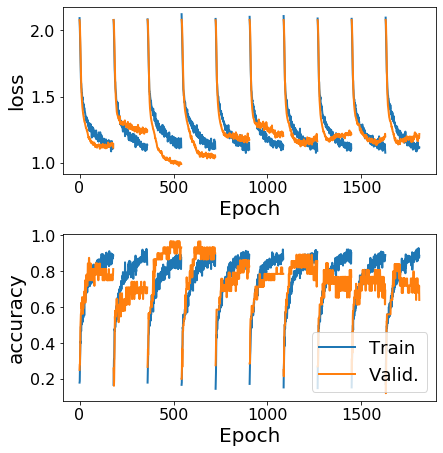

In [38]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_infos[1]['exp_code'], verbose=2)
quickplot_history(history)

### Training and evaluation - per session

Note that using verbose=0 will suppress most of the log information. Progress indicators might only be updated once every few minutes, depending on the number of epochs and the amount of time it takes to process a session.

In [39]:
hists = []
accs = []
for sess_info in sess_infos:
    _hist, _acc = get_hists_acc(sess_info['exp_code'], verbose=0)
    hists.append(_hist)
    accs.append(_acc)
    
print(accs)

Processing session sra3_2_j_037_00+03...
Found 160 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (160, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 71.875%
Processing session sra3_1_j_050_00+...
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.3157894736842%
Processing session sra3_1_j_051_00+...

## TODO
   
1. Use Capsules
1. Replace deeper conv layers with LSTM
    * Didn't seem to help
1. If using autoencoder, make sure AE on its own can reconstruct input reasonably well.
    * Couldn't get good AE working. Needs work.
1. Better model inspection (put code in indl)
    * tSNE different layers
    * Average saliency across channels vs time


## Inspecting the model

[Further info](http://cs231n.github.io/understanding-cnn/)



In [53]:
sess_id = sess_infos[1]['exp_code']
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
_y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
ds_all = rates2dataset(X_rates, _y, is_train=True, batch_size=BATCH_SIZE)

Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


In [58]:
# Train a model using ALL data
tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(
    ds_all.element_spec[0],
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy', 'AUC'])

best_model_path = f'rates2class_{sess_id}_all.h5'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=best_model_path,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='accuracy',
        verbose=2)
]
hist = model.fit(x=ds_all, epochs=EPOCHS,
                 callbacks=callbacks,
                 verbose=2)

Train for 17 steps
Epoch 1/180

Epoch 00001: accuracy improved from -inf to 0.16176, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 1s - loss: 2.0977 - accuracy: 0.1618 - AUC: 0.5217
Epoch 2/180

Epoch 00002: accuracy improved from 0.16176 to 0.20588, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 2.0363 - accuracy: 0.2059 - AUC: 0.6653
Epoch 3/180

Epoch 00003: accuracy improved from 0.20588 to 0.28676, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.9748 - accuracy: 0.2868 - AUC: 0.7334
Epoch 4/180

Epoch 00004: accuracy improved from 0.28676 to 0.38235, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.8814 - accuracy: 0.3824 - AUC: 0.8020
Epoch 5/180

Epoch 00005: accuracy improved from 0.38235 to 0.42647, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.8006 - accuracy: 0.4265 - AUC: 0.8402
Epoch 6/180

Epoch 00006: accuracy did not improve from 0.42647
17/17 - 0s - loss: 1

Epoch 59/180

Epoch 00059: accuracy did not improve from 0.76103
17/17 - 0s - loss: 1.2674 - accuracy: 0.7390 - AUC: 0.9715
Epoch 60/180

Epoch 00060: accuracy improved from 0.76103 to 0.76471, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.2185 - accuracy: 0.7647 - AUC: 0.9774
Epoch 61/180

Epoch 00061: accuracy improved from 0.76471 to 0.76838, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.2422 - accuracy: 0.7684 - AUC: 0.9758
Epoch 62/180

Epoch 00062: accuracy did not improve from 0.76838
17/17 - 0s - loss: 1.2699 - accuracy: 0.7243 - AUC: 0.9695
Epoch 63/180

Epoch 00063: accuracy did not improve from 0.76838
17/17 - 0s - loss: 1.2584 - accuracy: 0.7316 - AUC: 0.9730
Epoch 64/180

Epoch 00064: accuracy improved from 0.76838 to 0.78676, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.2391 - accuracy: 0.7868 - AUC: 0.9741
Epoch 65/180

Epoch 00065: accuracy did not improve from 0.78676
17/17 - 0s - loss: 1

Epoch 120/180

Epoch 00120: accuracy did not improve from 0.86765
17/17 - 0s - loss: 1.1484 - accuracy: 0.8346 - AUC: 0.9872
Epoch 121/180

Epoch 00121: accuracy did not improve from 0.86765
17/17 - 0s - loss: 1.1674 - accuracy: 0.8309 - AUC: 0.9848
Epoch 122/180

Epoch 00122: accuracy did not improve from 0.86765
17/17 - 0s - loss: 1.1382 - accuracy: 0.8493 - AUC: 0.9890
Epoch 123/180

Epoch 00123: accuracy did not improve from 0.86765
17/17 - 0s - loss: 1.1561 - accuracy: 0.8419 - AUC: 0.9849
Epoch 124/180

Epoch 00124: accuracy improved from 0.86765 to 0.87868, saving model to rates2class_sra3_1_j_050_00+_all.h5
17/17 - 0s - loss: 1.1236 - accuracy: 0.8787 - AUC: 0.9895
Epoch 125/180

Epoch 00125: accuracy did not improve from 0.87868
17/17 - 0s - loss: 1.1475 - accuracy: 0.8529 - AUC: 0.9875
Epoch 126/180

Epoch 00126: accuracy did not improve from 0.87868
17/17 - 0s - loss: 1.1845 - accuracy: 0.8199 - AUC: 0.9820
Epoch 127/180

Epoch 00127: accuracy did not improve from 0.87868
17

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw spiketrains do not decompose to very well so for inputs we will use spikerates that are previously derived from the spike trains convolved with a gaussian kernel (sigma=50 msec).

In [92]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
tbs = 30  # tsne batch size

TEST_PERPLEXITY = 20  # 10, 30

def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    ax = plt.gca()
    ax.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    ax.set_xlabel('t-SNE D-1')
    ax.set_ylabel('t-SNE D-2')
    if perplexity is not None:
        title += f" (Ppx: {perplexity})"
    ax.set_title(title)

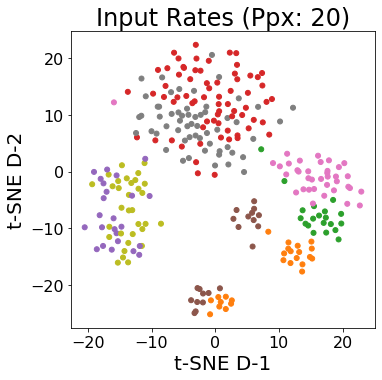

In [60]:
fig = plt.figure(figsize=(12, 12))

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X_rates.reshape([-1, np.prod(X_rates.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 1)
plot_tsne(tsne_values, Y_class.ravel()+1, TEST_PERPLEXITY, title='Input Rates')

In [102]:
# Let's create a version of our CNN model that goes from input to the bottleneck layer
model = tf.keras.models.load_model(best_model_path)
test_layer_idx = [3, 15, -1]
test_layers = [model.layers[_].output for _ in test_layer_idx]
truncated_model = tf.keras.Model(model.input, test_layers)
outputs = [[] for _ in range(len(test_layers))]
for start_ix in range(0, X_rates.shape[0], tbs):
    temp = X_rates[start_ix:start_ix+tbs].astype(np.float32)
    temp = truncated_model(temp)
    for layer_ix, res in enumerate(temp):
        outputs[layer_ix].append(res.numpy())

In [103]:
print(len(outputs[0]), outputs[0][0].shape, X_rates.shape)
results = []
for ix, tmp in enumerate(outputs):
    _tmp = np.concatenate(tmp, axis=0)
    print(_tmp.shape)
    results.append(_tmp.reshape([-1, np.prod(_tmp.shape[1:])]))
    
print([_.shape for _ in results])

10 (30, 32, 171, 8) (285, 32, 171)
(285, 32, 171, 8)
(285, 40)
(285, 8)
[(285, 43776), (285, 40), (285, 8)]


In [104]:
tf.keras.backend.clear_session()
model.layers

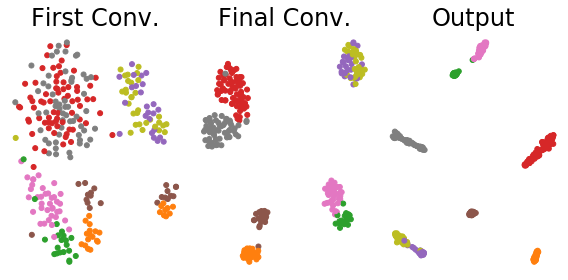

In [108]:
fig = plt.figure(figsize=(8, 4))
layer_titles = ["First Conv.", "Final Conv.", "Output"]

for layer_ix, flat_res in enumerate(results):
    if layer_ix == 0:
        pca = PCA(n_components=50)
        flat_res = pca.fit_transform(flat_res)
    tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
    tsne_values = tsne_model.fit_transform(flat_res)
    ax = plt.subplot(1, 3, layer_ix + 1)
    plot_tsne(tsne_values, Y_class.ravel()+1, None,
              title=layer_titles[layer_ix])  # f"Layer {test_layer_idx[layer_ix]}")
    ax.axis('off')

plt.tight_layout()
fig.savefig('tSNE_CNN_rates.png')

In [ ]:
# Model Rates
pca = PCA(n_components=50)
pca_values = pca.fit_transform(results[0])
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 2)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Features')

# Model Latents
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_latents)
plt.subplot(2, 2, 3)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Latents')

# Recon Rates
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_recon_rates)
plt.subplot(2, 2, 4)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Recon Features')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

In [ ]:
fig = plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
chan_ix = 31  # 4
_X = rates_X
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Smoothed Rates')

plt.subplot(2, 2, 2)
chan_ix = -4  # 4
_X = rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Convolved Spikes')

plt.subplot(2, 2, 4)
chan_ix = -4  # 4
_X = recon_rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Recon Features')

plt.tight_layout()

fig.savefig(str(datadir / (SESS_ID + '_example_rates.png')))

In [ ]:
import tensortools as tt

U = tt.cp_als(np.squeeze(rates_X), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

In [ ]:
U = tt.cp_als(np.squeeze(rates), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

### First convolutional layers
The first pair of convolutional layers are simply performing time-domain convolutions on the spike trains.
Whereas a typically signal processing pipeline will apply a gaussian, exponentional, or gamma kernel convolution,
here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

In [ ]:
import scipy.signal

fig = plt.figure(figsize=(12, 12))
t = ax_info['timestamps']

x_ranges = [[-0.02, 0.02], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

In [ ]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12))
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_SpatFilts.png')))

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Filter Activation-Maximizing Inputs

One useful way to understand what a convolutional layer is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer.

Remembering back to the step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [ ]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

In [ ]:
# 4 is DepthwiseConv2D, 9 is SeparableConv2D
plot_layer(9, max_filts=9)

### Class Maximizing Inputs
If we extend our reasoning from filter activations down to the next-to-last layer (15), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (16), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

In [ ]:
plot_layer(15, n_steps=100)

## Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
def get_losses_for_class(test_class):
    classes, y = np.unique(Y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id, MAX_OFFSET:, :].astype(np.float32)[None, :, :, None])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        losses_grads.append((loss_value, grads))
    return losses_grads

In [ ]:
# Plot saliency image for a few trials in a particular class
N_SALIENCY_TRIALS = 3
TEST_CLASS = 5  # -1 to 6
losses_grads = get_losses_for_class(TEST_CLASS)
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
re_ix = np.argsort(loss_vals)
b_class = np.squeeze(Y == TEST_CLASS)
_x = X[b_class, MAX_OFFSET:][re_ix][:N_SALIENCY_TRIALS]
_masks = grad_vals[re_ix][:N_SALIENCY_TRIALS]

fig = plt.figure(figsize=(8, 6), facecolor='white')
for tr_ix in range(N_SALIENCY_TRIALS):
    plt.subplot(N_SALIENCY_TRIALS, 1, tr_ix + 1)
    plt.imshow(_masks[tr_ix].T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    plt.eventplot([np.where(_)[0] for _ in _x[tr_ix].T], colors='k')
    for _t in t0_ix:
        plt.axvline(_t)
plt.xlabel('Sample')
plt.ylabel('Channel ID')
plt.tight_layout()

In [ ]:
# Plot average saliencies for all trials within each class
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

fig = plt.figure(figsize=(12, 18), facecolor='white')

for ix, class_id in enumerate(np.unique(Y)):
    losses_grads = get_losses_for_class(class_id)
    loss_vals = [_[0][0].numpy() for _ in losses_grads]
    grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
    grad_vals = np.mean(grad_vals, axis=0)
    plot_ix = 2 * ix + 1 * (ix < 4) - 6 * (ix >= 4)
    plt.subplot(4, 2, plot_ix)
    plt.imshow(grad_vals.T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    for _t in t0_ix:
        plt.axvline(_t)
    plt.title(str(class_id))
    if (ix + 1) % 4 == 0:
        plt.xlabel('Sample')
    if ix < 4:
        plt.ylabel('Channel')
plt.tight_layout()

## Class Activation Maps

Class activation maps (CAM) highlight the parts of the input that contribute most to each classification score. This is similar but different to saliency mapping. Whereas in saliency mapping the losses are back-propagated all the way back to the inputs, in CAM (or [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)) the per-class scores / losses are propaged backward only to the last convolutional layer. These losses are then used as the weights in a weighted average of the feature map output of the last convolutional layer. If the result is smaller than the input, it is then interpolated to match the input size.

Remember that in image classification the data have width pixels x height pixels x colour depths, but in our neural time-series data we have time samples x 1 x electrodes. We could use CAM on our timeseries data to identify which time points are important for each class but not channels because CAM averages across 'depth'. Time-point importance is unlikely to be informative in this dataset because it is unlikely that the timing of processing visual cues and creating motor plans is class-dependent, especially not at the time scales of the final convolution output (~100 msec).

To get any information about which channels of the input were important, we would have to project the losses back to before the spatial filter layer (`DepthwiseConv2D`).

TODO: Cluster channels based on cross-correlations of per-trial saliency maps.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    k_spike_short = params.get('k_spike_short', 10)
    l_spike_short = params.get('l_spike_short', 22)
    k_spike_long = params.get('k_spike_long', 4)
    l_spike_long = params.get('l_spike_long', 200)
    D = params.get('D', 4)
    downsamp_1 = params.get('downsamp_1', 5)
    n_pointwise_filters = params.get('n_pointwise_filters', 38)
    kern_length_2 = params.get('kern_length_2', 40)
    downsamp_2 = params.get('downsamp_2', 8)
    norm_rate = params.get('norm_rate', 0.3)
    dropout_rate = params.get('dropout_rate', 0.3)
    latent_dim = params.get('latent_dim', 10)
    gamma = params.get('gamma', 1.0)
    window_scale = params.get('window_scale', 1.0)
    l1_reg = params.get('l1_reg', 0.0002)
    l2_reg = params.get('l2_reg', 0.0002)
    epochs = params.get('epochs', 80)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=123)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    tf.keras.backend.clear_session()
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       k_spike_short=k_spike_short, l_spike_short=l_spike_short,
                       k_spike_long=k_spike_long, l_spike_long=l_spike_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    max_val_acc = max(history.history['val_accuracy'])
    print("Max validation accuracy with these parameters: {}".format(max_val_acc))
    
    tf.keras.backend.clear_session()
    
    return -max_val_acc

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest

space = {
#     'k_spike_short': scope.int(hp.quniform('k_spike_short', 1, 15, 1)),
#     'l_spike_short': scope.int(hp.quniform('l_spike_short', 8, 50, 2)),
    'k_spike_long': scope.int(hp.quniform('k_spike_long', 1, 15, 1)),
#     'l_spike_long': scope.int(hp.quniform('l_spike_long', 60, 250, 5)),
#     'D': scope.int(hp.quniform('D', 1, 12, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 4, 10, 1)),
#     'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 64, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 9, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     '12_reg': hp.loguniform('l1_reg', np.log(0.000001), np.log(1.0)),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(1.0)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
    'latent_dim': scope.int(hp.quniform('latent_dim', 5, 50, 5)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(100)),
    'window_scale': hp.loguniform('window_scale', np.log(1e-4), np.log(100))
}    

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 5.
minutes_per_eval = 2.5
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
print("Best Acc: {}".format(-trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

In [ ]:
def scatterplot_matrix_colored(params_names, params_values, best_losses,
                               alpha=0.3, minmax='min'):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    
    best_losses = np.array(best_losses)
    if minmax == 'min':
        best_trial = np.argmin(best_losses)
    else:
        best_trial = np.argmax(best_losses)
        
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
            axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=alpha,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored according to best validation loss')
    plt.show()

# Prepare loss values. Maybe transform.
hp_loss = np.array([_['result']['loss'] for _ in trials.trials])
hp_loss = -hp_loss

hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
log_hps = [_ for _ in ['l1_reg', 'l2_reg', 'window_scale', 'gamma'] if _ in hp_names]
for hp_name in log_hps:
    hp_vals[hp_names.index(hp_name)] = np.log10(hp_vals[hp_names.index(hp_name)])

scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, minmax='max',
                           alpha=0.8)
print(np.max(hp_loss))

In [ ]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull', 'EEGNet\n& AE']
accuracies = [[30.2, 43.4, 61.2, 72.3, 76.1, 69.9],[36.8, 46.5, 81.1, 85.4, 85.5, 82.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()
plt.tight_layout()

fig.savefig(str(datadir / ('Acc_Bars.png')))